In [2]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from helper_code_qutip import *
from scipy import integrate
import scipy.io

In [3]:
import time

In [6]:
Tc_list = [0.001,0.18,0.20]
Th_list = [0.4,0.7,1.0] #For some reason, integral diverges outside this range


betalist1 = [1/Tc for Tc in Tc_list]
betalist2 = [1/Th for Th in Th_list]

gvals1 = list(np.linspace(0.001,0.01,50))
gvals2 = list(np.linspace(0.01,1,150))
gvals3 = list(np.linspace(1,10,50))

## Add the two lists
gvals = gvals1 + gvals2
gvals_ext = gvals + gvals3

gvals_1 = [1.6e-3]


print(len(betalist1),len(betalist2))

redfield_ss = []
lle_ss = []
lle_ss2 = []
e = 0.01
for beta2 in betalist2:
    list_lle2 = []
    for g in gvals_1:
        t0 = time.time()
        limit_value=700
        b=500
        N=6
        w0min=1
        w0max=1
        delta=1
        gmin=g
        gmax=g
            
        w0list=np.linspace(w0min,w0max,N)
        glist=np.linspace(gmin,gmax,N-1)
            
        tb=0.01
        epsilon=1
        gamma1=1e-3 #gamma1 is the coupling to left bath. It shows up in spectral bath function
        #gamma2=1.1e-2   #gamma2 is the coupling to the right bath.    
            
            

        mu=0
            
            
        delta=1
        mu1=mu
        mu2=mu

        H_S=create_hamiltonian(w0list,glist,delta,N)
    
    
        #c_N=create_sm(N,N)  # we couple the Nth spin to the bath
        c_1=create_sm(N,1)
        
        
        
        eigenergies,eigstates=H_S.eigenstates()
        
        #print("eigenenergies are : ",eigenergies)
        
        spectrum=max(eigenergies)-min(eigenergies)
        
        
        
        number=len(eigenergies)

        gammah_plus =  gamma1*nbar(1,beta2,mu)
        gammah_minus = gamma1*(nbar(1,beta2,mu)+1)

        Delta1=(-1.0*epsilon*epsilon/(2*np.pi))*integrate.quad(spectral_bath,0,b,args=(tb,gamma1),weight='cauchy',wvar=w0list[0])[0] #Delta
        Deltadash1=(-1.0*epsilon*epsilon/(2*np.pi))*integrate.quad(func1,0,b,args=(tb,beta2,mu2,gamma1),weight='cauchy',wvar=w0list[0])[0] #Delta
        
        H=H_S  +(Deltadash1+0.5*Delta1)*create_sigmaz(N,1)
        L_lle = spre(-1.0j*(H)) + spost(1.0j*(H))
        op1 = create_sm(N,1).dag()

        L_lle = L_lle + gammah_plus*(spectral_bath(1,tb,1))*(spre(op1)*spost(op1.dag()) - 0.5*spre(op1.dag()*op1) - 0.5*spost(op1.dag()*op1)) + gammah_minus*(spectral_bath(1,tb,1))*(spre(op1.dag())*spost(op1) - 0.5*spre(op1*op1.dag()) - 0.5*spost(op1*op1.dag()))
        ss_lindblad2 = steadystate(L_lle)

        print("Time taken for g = ",g," and N = ",N,  " is ",time.time()-t0)
        L_eigen = L_lle.eigenenergies()
        print("Smallest eigenvalues of L_lle2 are ", L_eigen[-3:])
        list_lle2.append(ss_lindblad2)
    lle_ss2.append(list_lle2)
    

3 3
Time taken for g =  0.0016  and N =  6  is  16.556323051452637
Smallest eigenvalues of L_lle2 are  [-1.00656297e-05-1.00283195e+00j -1.00656297e-05+1.00283195e+00j
 -1.21913118e-16-2.57581951e-15j]
Time taken for g =  0.0016  and N =  6  is  13.495460271835327
Smallest eigenvalues of L_lle2 are  [-1.40173350e-05+1.00283138e+00j -1.40173350e-05-1.00283138e+00j
 -1.71147281e-15+8.85038177e-15j]
Time taken for g =  0.0016  and N =  6  is  12.590105533599854
Smallest eigenvalues of L_lle2 are  [-1.78821119e-05+1.00282905e+00j -1.78821119e-05-1.00282905e+00j
 -1.48307455e-15+2.64929080e-15j]


In [14]:
def e_l(l,w0list,glist,delta,rho_ss):
    print("Calculating e_l for l = ",l)
    if l==1:
        op = (w0list[l-1]/2)*create_sigmaz(N,l) - 0.5*glist[l-1]*(create_sigmax(N,l)*create_sigmax(N,l+1) + create_sigmay(N,l)*create_sigmay(N,l+1) + delta*create_sigmaz(N,l)*create_sigmaz(N,l+1))
        ##Calculate expectation value of this operator wrt rho_ss
        return expect(op,rho_ss)
    elif l==N:
        op = (w0list[l-1]/2)*create_sigmaz(N,l) - 0.5*glist[l-2]*(create_sigmax(N,l-1)*create_sigmax(N,l) + create_sigmay(N,l-1)*create_sigmay(N,l) + delta*create_sigmaz(N,l-1)*create_sigmaz(N,l))
        ##Calculate expectation value of this operator wrt rho_ss
        return expect(op,rho_ss)
    
    else:
        op = (w0list[l-1]/2)*create_sigmaz(N,l) - 0.5*glist[l-1]*(create_sigmax(N,l)*create_sigmax(N,l+1) + create_sigmay(N,l)*create_sigmay(N,l+1) + delta*create_sigmaz(N,l)*create_sigmaz(N,l+1)) - 0.5*glist[l-2]*(create_sigmax(N,l-1)*create_sigmax(N,l) + create_sigmay(N,l-1)*create_sigmay(N,l) + delta*create_sigmaz(N,l-1)*create_sigmaz(N,l))
        ##Calculate expectation value of this operator wrt rho_ss
        return expect(op,rho_ss)

In [21]:
def el_plot(w0list,glist,delta,ss_list):
    for i in range(1,2):
        #for j in range(len(gvals)):
        ss = ss_list[i][0]
        elist = [e_l(l,w0list,glist,delta,ss) for l in range(1,N+1)]
        print("e_l for Th = ",Th_list[i]," is ",elist)
        plt.plot(range(1,N+1),elist,label = "Th = "+str(Th_list[i]))

    plt.xlabel("l")
    plt.ylabel("e_l")
    plt.legend()
    plt.title("e_l vs l for different Th")
    plt.show()

Calculating e_l for l =  1
Calculating e_l for l =  2
Calculating e_l for l =  3
Calculating e_l for l =  4
Calculating e_l for l =  5
Calculating e_l for l =  6
e_l for Th =  0.7  is  [-0.3069795959007944, -0.30728056160389916, -0.3072805616038966, -0.3072805616038956, -0.3072805616038988, -0.30697959590079615]


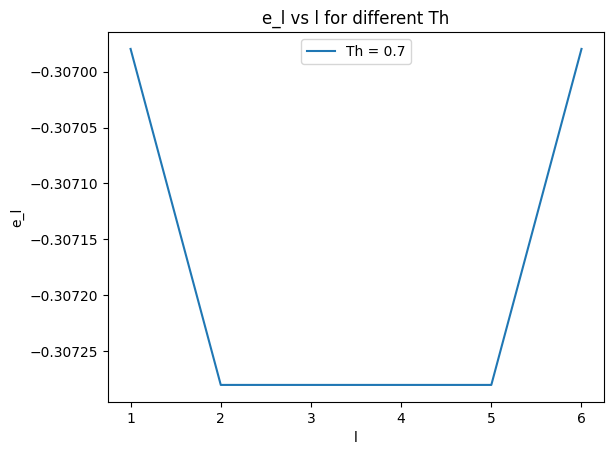

In [22]:
w0list=np.linspace(1,1,N)
glist=np.linspace(gvals_1[0],gvals_1[0],N-1)
delta = 1
el_plot(w0list,glist,delta,lle_ss2)